In [166]:
import pickle
import os
import matplotlib.pyplot as plt
import os
import sys

import PIL
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from matplotlib.colors import Normalize
from PIL import Image
from scipy.stats import percentileofscore
from tqdm import tqdm
import torch.nn.functional as F
import torch

In [451]:
results_dir = 'experiments/results'
exp_code = 'exp_137_s1'
split = 0

In [452]:
def load_pkl(filename):
	loader = open(filename,'rb')
	file = pickle.load(loader)
	loader.close()
	return file

In [453]:
heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl"))

In [473]:
img_index = 23

In [474]:
A = heatmap_dict[img_index]["attention_scores"][0]
att = A.reshape(7, 11)

In [475]:
A = torch.Tensor(A)

In [476]:
A = F.softmax(A, dim=0)

In [477]:
A.view(7, 11)

tensor([[0.0041, 0.0222, 0.0157, 0.0071, 0.0046, 0.0016, 0.0018, 0.0026, 0.0200,
         0.0258, 0.0127],
        [0.0049, 0.0216, 0.0088, 0.0057, 0.0038, 0.0081, 0.0229, 0.0091, 0.0006,
         0.0005, 0.0229],
        [0.0161, 0.0270, 0.0087, 0.0033, 0.0030, 0.0048, 0.0025, 0.0025, 0.0195,
         0.0187, 0.0260],
        [0.0001, 0.0003, 0.0050, 0.0096, 0.0077, 0.0027, 0.0066, 0.0244, 0.0291,
         0.0279, 0.0274],
        [0.0025, 0.0019, 0.0073, 0.0117, 0.0133, 0.0076, 0.0109, 0.0265, 0.0198,
         0.0247, 0.0186],
        [0.0074, 0.0026, 0.0046, 0.0047, 0.0122, 0.0225, 0.0243, 0.0256, 0.0229,
         0.0169, 0.0237],
        [0.0097, 0.0020, 0.0025, 0.0100, 0.0265, 0.0256, 0.0218, 0.0161, 0.0247,
         0.0249, 0.0242]])

In [505]:
percentiles = []
scores = 1 - A.numpy()
for score in scores:
    percentile = percentileofscore(scores, score)
    percentiles.append(percentile / 100)
percentiles = np.asarray(percentiles)
percentiles

array([0.76623377, 0.28571429, 0.42857143, 0.64935065, 0.75324675,
       0.94805195, 0.93506494, 0.84415584, 0.32467532, 0.1038961 ,
       0.45454545, 0.7012987 , 0.31168831, 0.55844156, 0.67532468,
       0.77922078, 0.58441558, 0.25974026, 0.54545455, 0.96103896,
       0.97402597, 0.23376623, 0.4025974 , 0.05194805, 0.57142857,
       0.79220779, 0.80519481, 0.71428571, 0.87012987, 0.88311688,
       0.35064935, 0.36363636, 0.09090909, 1.        , 0.98701299,
       0.68831169, 0.53246753, 0.5974026 , 0.81818182, 0.66233766,
       0.18181818, 0.01298701, 0.02597403, 0.03896104, 0.85714286,
       0.92207792, 0.63636364, 0.48051948, 0.44155844, 0.61038961,
       0.49350649, 0.06493506, 0.33766234, 0.15584416, 0.37662338,
       0.62337662, 0.83116883, 0.74025974, 0.72727273, 0.46753247,
       0.27272727, 0.19480519, 0.12987013, 0.24675325, 0.38961039,
       0.22077922, 0.51948052, 0.90909091, 0.8961039 , 0.50649351,
       0.07792208, 0.11688312, 0.2987013 , 0.41558442, 0.16883

In [506]:
predictions = percentiles

In [507]:
def calculate_stride(size, overlap):
    return tuple(int(s * (1 - overlap)) for s in size)

In [508]:
def make_tilemap(
    predictions,
    tilemap_shape,
    patch_size=(224, 224, 3),
    cmap="coolwarm",
    overlap=0.5,
    percentile_scale=None,
    percentile_score=False,
):
    """
    Generate a tilemap from model predictions.

    Parameters:
    - predictions (numpy.ndarray): Model predictions for patches.
    - tilemap_shape (tuple): Shape of the tilemap (rows, cols).
    - patch_size (tuple): Size of each patch (height, width, channels).
    - cmap (str): Colormap for coloring the tiles.
    - overlap (float): Overlap factor.
    - percentile_scale (tuple): Percentile values for scaling the predictions.
    - percentile_score (bool): Whether to use percentile scores for coloring.

    Returns:
    - tilemap (numpy.ndarray): Image with overlaid colored tiles.
    """
    num_patches = len(predictions)
    cmap = plt.cm.get_cmap(cmap)
    norm = Normalize(vmin=0, vmax=1)
    tilemap_size = (
        tilemap_shape[0] * patch_size[0]
        - int(overlap * (tilemap_shape[0] - 1) * patch_size[0]),
        tilemap_shape[1] * patch_size[1]
        - int(overlap * (tilemap_shape[1] - 1) * patch_size[1]),
        patch_size[2],
    )
    tilemap = np.zeros(tilemap_size, dtype=np.float32)
    tilemap_counter = np.zeros(tilemap_size[:2], dtype=np.int32)
    stride = calculate_stride(patch_size[:2], overlap)

    if percentile_scale is not None:
        # Apply percentile scaling to predictions
        min_percentile, max_percentile = percentile_scale
        min_value = np.percentile(predictions, min_percentile)
        max_value = np.percentile(predictions, max_percentile)
        predictions = np.clip(predictions, min_value, max_value)
        predictions = (predictions - min_value) / (max_value - min_value)

    if percentile_score:
        percentiles = []
        for score in predictions:
            percentile = percentileofscore(predictions, score)
            percentiles.append(percentile / 100)
        predictions = percentiles

    for i, pred in enumerate(predictions):
        row, col = divmod(i, tilemap_shape[1])
        top_left_row = row * stride[0]
        top_left_col = col * stride[1]

        pred = norm(pred)
        color = np.squeeze(cmap(pred))[:-1]  # Exclude alpha channel

        # Normalize the prediction value to the range [0, 1]
        # normalized_pred = (pred - 0.5) * 2  # Map [0.5, 1] to [0, 1]
        # normalized_pred = np.clip(normalized_pred, 0, 1)  # Clip to [0, 1]

        # Create a red color with intensity based on the normalized prediction value
        # color = np.array([normalized_pred, 0, 0])

        tilemap[
            top_left_row : top_left_row + patch_size[0],
            top_left_col : top_left_col + patch_size[1],
            :,
        ] += color
        tilemap_counter[
            top_left_row : top_left_row + patch_size[0],
            top_left_col : top_left_col + patch_size[1],
        ] += 1

    # Normalize by the number of patches contributing to each region
    tilemap /= np.maximum(tilemap_counter, 1)[:, :, np.newaxis]
    tilemap = (tilemap * 255).astype(np.uint8)

    return tilemap

In [509]:
def superimpose(background, overlay, alpha=0.4, blur=None):
    """
    Superimpose an overlay image onto a background image.

    Parameters:
    - background (numpy.ndarray): Background image, np.uint8;
    - overlay (numpy.ndarray): Overlay image, np.uint8;
    - alpha (float): Transparency factor for the overlay (0.0 to 1.0).
    - blur (tuple): Kernel size for blurring the overlay.

    Returns:
    - superimposed_image (numpy.ndarray): Resulting superimposed image, np.uint8;
    """
    background = background[: overlay.shape[0], : overlay.shape[1], :]

    if background.shape != overlay.shape:
        raise ValueError("Background and overlay images must have the same shape.")

    if blur:
        overlay = cv2.blur(overlay, blur)

    superimposed_pil = Image.blend(
        Image.fromarray(background), Image.fromarray(overlay), alpha
    )
    superimposed_image = np.array(superimposed_pil)

    return superimposed_image

In [510]:
tilemap = make_tilemap(predictions=predictions,
        tilemap_shape=(7, 11),
        patch_size=(256, 256, 3),
        cmap="coolwarm",
        overlap=0.5,
        percentile_scale=None,
        percentile_score=False,)

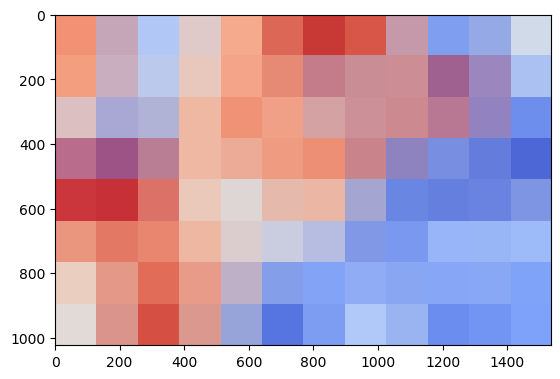

In [511]:
plt.imshow(tilemap)

In [512]:
image_name = heatmap_dict[img_index]["filename"]
image_name

'F053a17'

In [513]:
data_dir = "experiments/annotations/original/"
image_ext = ".tif"

In [514]:
img_path = os.path.join(data_dir, image_name + image_ext)

In [515]:
orig_img = PIL.Image.open(img_path)
orig_img = np.asarray(orig_img)

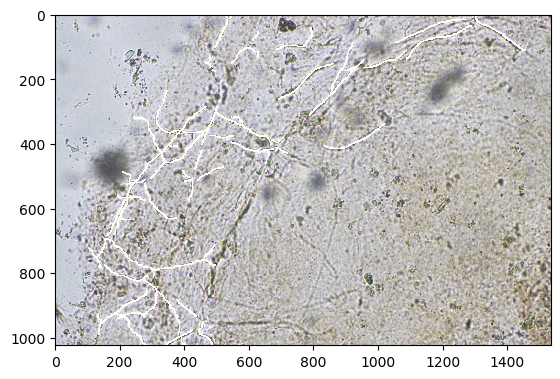

In [516]:
heatmap = superimpose(orig_img, tilemap, alpha=0, blur=(128,128))
plt.imshow(heatmap)

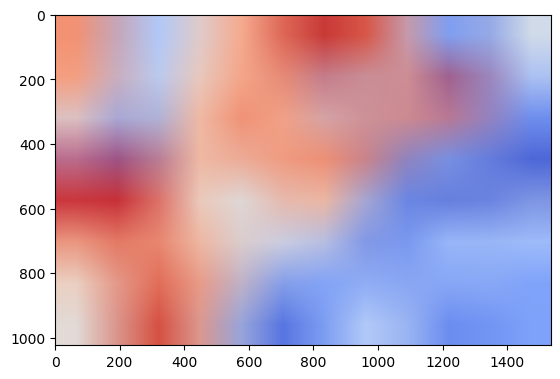

In [517]:
heatmap = superimpose(orig_img, tilemap, alpha=1, blur=(128,128))
plt.imshow(heatmap)

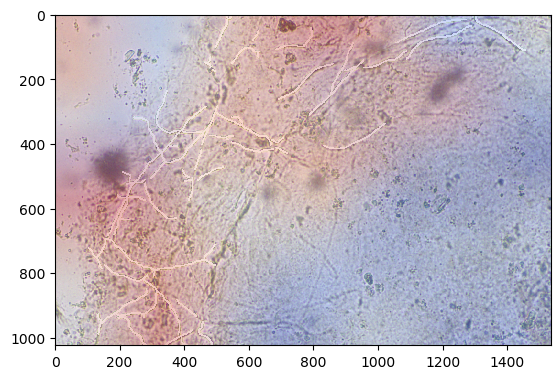

In [518]:
heatmap = superimpose(orig_img, tilemap, alpha=0.4, blur=(128,128))
plt.imshow(heatmap)